In [33]:
import yt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import constants as C

In [2]:
ds_array = []
for ii in range(10):
    ds_array = np.append( ds_array, 
                         yt.TipsyDataset('run699v2.0'+'%02d'%(ii+1)+'00', dataset_type='tipsy', 
                                         unit_base = {"mass":(2.33e5, "Msun")}) )

yt : [INFO     ] 2019-05-13 14:52:43,218 Parameters: current_time              = 1.0000000000000007
yt : [INFO     ] 2019-05-13 14:52:43,219 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2019-05-13 14:52:43,220 Parameters: domain_left_edge          = None
yt : [INFO     ] 2019-05-13 14:52:43,221 Parameters: domain_right_edge         = None
yt : [INFO     ] 2019-05-13 14:52:43,223 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-05-13 14:52:43,336 Allocating for 2.639e+06 particles (index particle type 'all')
yt : [INFO     ] 2019-05-13 14:52:43,642 Adding 2.639e+06 particles
yt : [INFO     ] 2019-05-13 14:52:44,011 Identified 1.604e+05 octs
yt : [INFO     ] 2019-05-13 14:52:45,460 Parameters: current_time              = 2.0000000000000013
yt : [INFO     ] 2019-05-13 14:52:45,461 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2019-05-13 14:52:45,462 Parameters: domain_left_edge          = None
yt : [INFO     ] 2019-05-13 14:52:45,473

In [3]:
50# The centers
cen_array = np.zeros((10, 3))
cen_dwarf = np.array([[54.7, -2.5, 152], [-7.8,1.6,-14], [-25.7,4.7,30]])

for ii in range(len(ds_array)):
    ds = ds_array[ii]
    density = ds.all_data()[('Gas', 'Density')]
    target = np.where(density == density.max())[0][0]
    del density
    centerHost = ds.all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
    if ii == 1:
        centerHost = [27.6, -1.6, 29.5]
    sphHost0 = ds.sphere(centerHost, (4, 'kpc'))
    centerHost = sphHost0.quantities.center_of_mass(use_gas=False,
                                                    use_particles=True,
                                                    particle_type='Stars')
    cen_array[ii] = centerHost

for jj in range(3):
    ds = ds_array[jj]
    sphDwarf0 = ds.sphere(cen_dwarf[jj], (4, 'kpc'))
    cen_dwarf[jj] = sphDwarf0.quantities.center_of_mass(use_gas=False,
                                                    use_particles=True,
                                                    particle_type='Stars')

In [45]:
ii = 5
ds = ds_array[ii]
centerHost = cen_array[ii]
sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
#计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
norm_host = sphHost_4_norm.quantities.angular_momentum_vector(
    use_gas=False, use_particles=True, particle_type='Stars')
north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]
sphDwarf = ds.sphere(cen_dwarf[0], (4, 'kpc'))
norm_dwa = sphDwarf.quantities.bulk_velocity(use_gas=False,
                                             use_particles=True,
                                             particle_type='Stars')
north_dwa = yt.YTArray(yt.ortho_find(norm_dwa), 'kpc')[1]

/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/units/yt_array.py:1394: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


yt : [INFO     ] 2019-05-13 16:43:18,563 Projection completed
yt : [INFO     ] 2019-05-13 16:43:18,564 xlim = -50.000000 50.000000
yt : [INFO     ] 2019-05-13 16:43:18,564 ylim = -50.000000 50.000000
yt : [INFO     ] 2019-05-13 16:43:18,565 xlim = -50.000000 50.000000
yt : [INFO     ] 2019-05-13 16:43:18,566 ylim = -50.000000 50.000000
yt : [INFO     ] 2019-05-13 16:43:18,568 Making a fixed resolution buffer of (('deposit', 'Stars_density')) 800 by 800



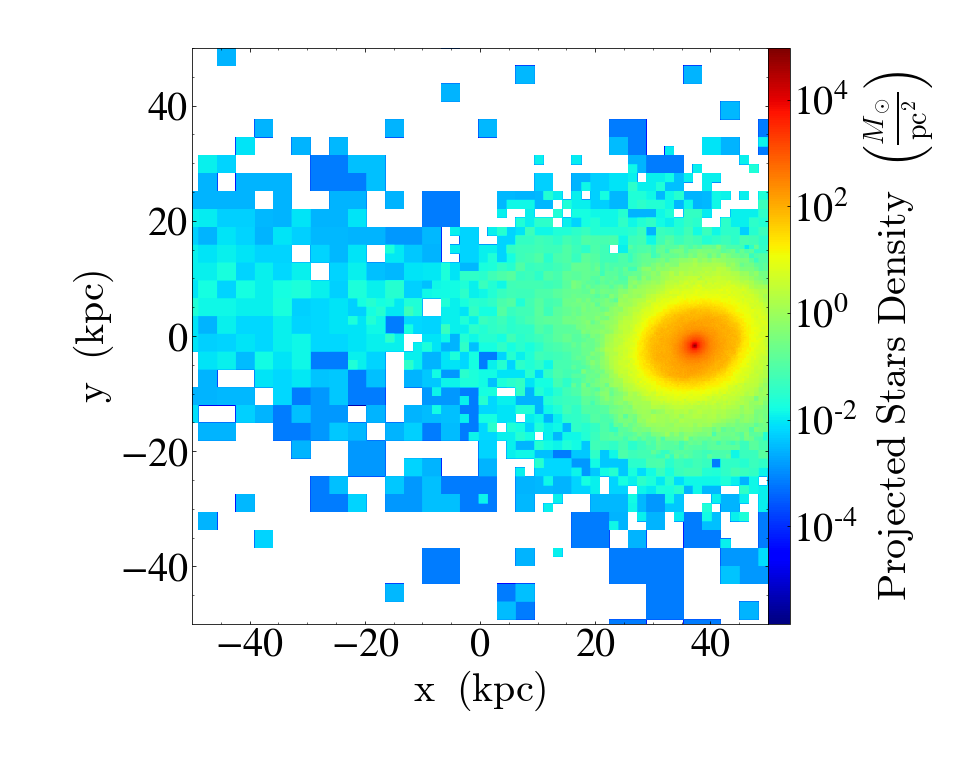

In [46]:
#全局的恒星质量密度分布 [0,0,0]
pp_all_star = yt.ProjectionPlot(ds,
                                'z', ('deposit', 'Stars_density'),
                                center=[0,0,0],
                                width=(100, "kpc"),
                                method='integrate',
                                fontsize=40)
pp_all_star.set_unit(('deposit', 'Stars_density'), 'Msun/pc**2')
pp_all_star.set_cmap(('deposit', 'Stars_density'), 'jet')
#pp_all_star.save('694_200_all_star.pdf')
pp_all_star

In [28]:
resolve = 0.1 * yt.units.kpc
from astropy.io import fits
obs = fits.open('fits/699_06_1.fits')
from astropy.table import Table
cata = Table.read('fits/699_06_1.txt', format='ascii')
ell = cata['col7'].copy()
ell[ell=='INDEF'] = np.nan
ell = ell.astype('float')

In [43]:
r_3 = cata['col2'][np.where(np.gradient(ell)==np.gradient(ell)[~np.isnan(np.gradient(ell))].min())][0]*resolve
height = 4 * yt.units.kpc
r_3

18.5 kpc

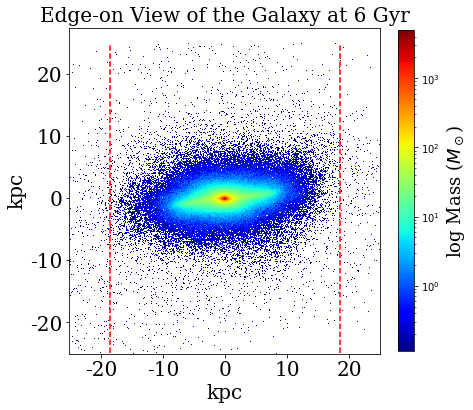

In [39]:
pic = obs[0].data.copy()
fig = plt.figure(figsize=(8,6))
plt.imshow(pic, cmap='jet', origin='low', norm=matplotlib.colors.LogNorm())
plt.ylabel('kpc',fontsize=20, family='serif', weight='ultralight')
plt.xlabel('kpc',fontsize=20, family='serif', weight='ultralight')
plt.xticks(fontsize=15, family='serif')
plt.yticks(fontsize=15, family='serif')
#plt.ylim((plt.ylim()))
plt.ylim([-20,20+np.shape(pic)[0]])
line_position = [r_3/resolve + np.round(0.5*np.shape(pic)[1]),
                 -r_3/resolve + np.round(0.5*np.shape(pic)[1]),
                0, np.shape(pic)[0]]
plt.vlines( x=line_position[0], ymin=line_position[2], ymax=line_position[3],
           colors='red', linestyle="--" )
plt.vlines( x=line_position[1], ymin=line_position[2], ymax=line_position[3],
           colors='red', linestyle="--" )
plt.colorbar(fraction=0.036, pad=0.04,).set_label(label='log Mass ($M_\odot$)',
                                                  fontsize=18, family='serif', weight='ultralight')
# divide the axis to 5 pieces
ax=plt.gca()
stepx = np.floor(pic.shape[1]/4/ 5*resolve.to_value())* 5/resolve.to_value()
stepy = np.floor(pic.shape[0]/4/ 5*resolve.to_value())* 5/resolve.to_value()
ax.set_xticks(((np.arange(5)-2)*stepx + pic.shape[1]/2))  
ax.set_yticks(((np.arange(5)-2)*stepy + pic.shape[0]/2)) 
# set them to be multiple of 10 arcsec
ax.set_xticklabels(((np.arange(5)-2)*stepx*resolve.to_value()).astype('int').astype('str'),
                   fontsize=20, family='serif', weight='ultralight')
ax.set_yticklabels(((np.arange(5)-2)*stepy*resolve.to_value()).astype('int').astype('str'),
                   fontsize=20, family='serif', weight='ultralight')
plt.title('Edge-on View of the Galaxy at 6 Gyr', fontsize=20, family='serif', weight='ultralight')
#plt.savefig('figs/All_stars_699.png', dpi=500, bbox_inches='tight')
plt.show()

yt : [INFO     ] 2019-05-13 17:43:46,759 xlim = -20.000000 20.000000
yt : [INFO     ] 2019-05-13 17:43:46,760 ylim = -20.000000 20.000000
yt : [INFO     ] 2019-05-13 17:43:46,760 zlim = -2.000000 2.000000
yt : [INFO     ] 2019-05-13 17:43:46,761 Making a fixed resolution buffer of (('deposit', 'Stars_density')) 800 by 800



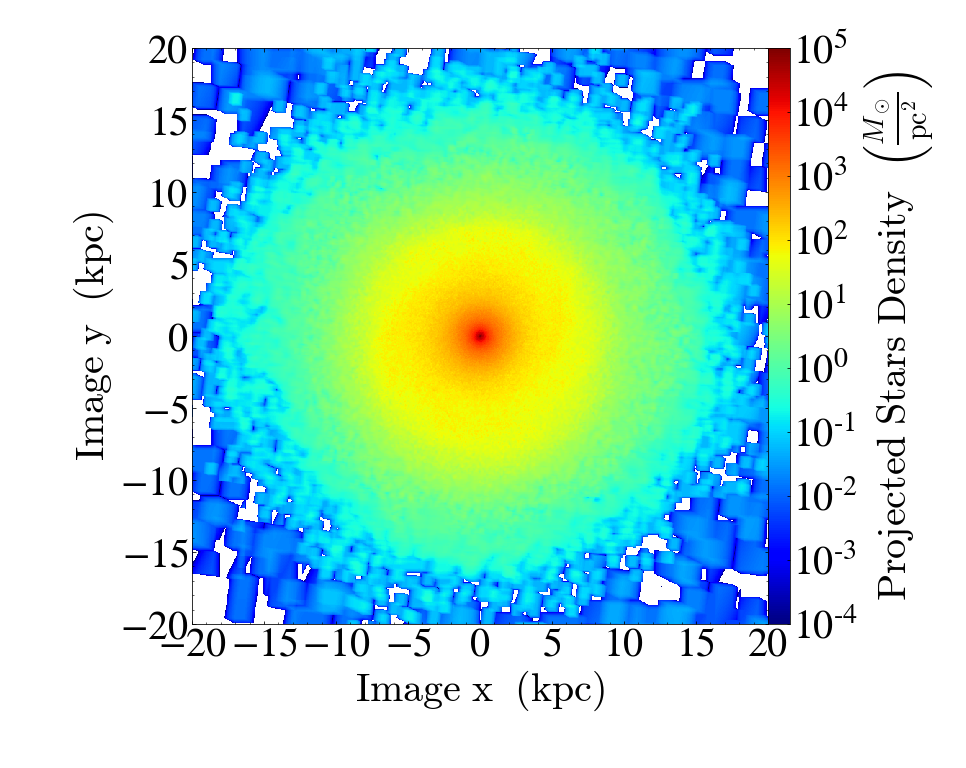

In [68]:
# 计算 host 垂直法相的恒星面密度和气体面密度
pp_host_star = yt.OffAxisProjectionPlot(ds,
                                        norm_host,
                                        ('deposit', 'Stars_density'),
                                        center=centerHost,
                                        width=(40, "kpc"),
                                        north_vector=north_host,
                                        method='integrate',
                                        depth=(height.item(), 'kpc'),
                                        fontsize=40)
# 作 host 恒星密度图
pp_host_star.set_unit(('deposit', 'Stars_density'), 'Msun/pc**2')
pp_host_star.set_cmap(('deposit', 'Stars_density'), 'jet')
pp_host_star.set_zlim(('deposit', 'Stars_density'), 1e-4, 1e5)
#pp_host_star.save('694_680_host_star.pdf')
pp_host_star

In [70]:
# 定义平均意义下的密度计算函数，返回值是两个数组，x 量被划分为多个区间，y 量在对应的区间内被平均
def Density_and_Thick_Profile( x_field, xunits, y_field, yunits, z_field, zunits, n_bins ):
    import numpy as np
    xaxis   = yt.YTArray(np.zeros(n_bins), xunits)
    yaxis_t = yt.YTArray(np.zeros(n_bins), yunits)
    yaxis   = yt.YTArray(np.zeros(n_bins), yunits+'/'+xunits+'**2')
    zaxis_t = yt.YTArray(np.zeros((n_bins,n_bins)), yunits)
    zaxis   = yt.YTArray(np.zeros((n_bins,n_bins)), yunits+'/'+xunits+'**3')
    xstep   = (50*yt.units.kpc).in_units(xunits)  / n_bins
    zstep   = np.fabs(z_field).max() / n_bins
    locatex = locatez = 0;
        
    for jj in range(n_bins):# total mass profile
        booleanx = (x_field.in_units(xunits)>jj*xstep) & (x_field.in_units(xunits)<=(jj+1)*xstep)
        yaxis_t[jj] = ( y_field[booleanx].in_units(yunits) ).sum()
    
    for ii in range(n_bins):# radius and density profile
        xaxis[ii] = ii * xstep
        yaxis[ii] = yaxis_t[ii] / (C.pi*(2*ii+1)*xstep**2)
        zaxis[ii] = zaxis_t[ii] / (C.pi*(2*ii+1)*xstep**2) / (2*zstep)
    
    return([xaxis, yaxis, zaxis])

def Age_profile( x_field, xunits, y_field, yunits, z_field, zunits, n_bins ):
    import numpy as np
    xaxis   = yt.YTArray(np.zeros(n_bins), xunits)
    yaxis_t = yt.YTArray(np.zeros(n_bins), yunits+'*'+zunits)
    yaxis   = yt.YTArray(np.zeros(n_bins), yunits)
    zaxis_t = yt.YTArray(np.zeros((n_bins)), zunits)
    xstep   = (50*yt.units.kpc).in_units(xunits)  / n_bins
    locatex = 0;
        
    for jj in range(n_bins):# total mass profile
        boolean = (x_field.in_units(xunits)>jj*xstep) & (x_field.in_units(xunits)<=(jj+1)*xstep)
        # evrey radius bin, weighted by mass of stars
        yaxis_t[jj] = (y_field[boolean].in_units(yunits) * z_field[boolean].in_units(zunits)).sum()
        zaxis_t[jj] = z_field[boolean].sum().in_units(zunits)
    for ii in range(n_bins):# radius and density profile
        xaxis[ii] = ii * xstep
        yaxis[ii] = yaxis_t[ii] / zaxis_t[ii]
    
    return([xaxis, yaxis])

In [9]:
def Profiles(ds_list):
    stellar_profiles = yt.YTArray(np.zeros((len(ds_list),bins)), 'Msun/kpc**2')
    for ii in range(len(ds_list)):
        ds = ds_list[ii]
        centerHost = cen_array[ii]
        sphHost1 = ds.sphere(centerHost, (4, 'kpc'))
        sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
        #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
        norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
        north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]
        # 计算半径和恒星柱密度曲线
        host_galaxy     = ds.disk(centerHost, norm_host, (50, "kpc"), (15, "kpc"))
        r_cylindrical  = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')
        [xaxis, yaxis, zaxis] = Density_and_Thick_Profile( r_cylindrical, 'kpc', host_galaxy[('Stars', 'particle_mass')], 'Msun', host_galaxy[('Stars', 'particle_position_relative_z')], 'kpc', bins )
        stellar_profiles[ii] = yaxis
    return [xaxis, stellar_profiles]
bins = 150
[xaxis, profiles] = Profiles(ds_array)

/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_velocity_relative' field has been deprecated in favor of 'relative_particle_velocity'.
  dd = self._function(self, data)
/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_position_relative' field has been deprecated in favor of 'relative_particle_position'.
  dd = self._function(self, data)


In [10]:
def Age_Profiles(ds_list):
    stellar_profiles = yt.YTArray(np.zeros((len(ds_list),bins)), 'Gyr')
    for ii in range(len(ds_list)):
        ds = ds_list[ii]
        centerHost = cen_array[ii]
        sphHost1 = ds.sphere(centerHost, (4, 'kpc'))
        sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
        #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
        norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
        north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]
        # 计算半径和恒星柱密度曲线
        host_galaxy     = ds.disk(centerHost, norm_host, (50, "kpc"), (15, "kpc"))
        r_cylindrical   = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')
        [radius, yaxis] = Age_profile(r_cylindrical, 'kpc', host_galaxy[('Stars', 'FormationTime')], 'Gyr',host_galaxy[('Stars', 'Mass')], 'Msun', bins)
        stellar_profiles[ii] = yaxis
        
    return [radius, stellar_profiles]

[xaxis, age_profiles] = Age_Profiles(ds_array)

/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/units/yt_array.py:1394: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


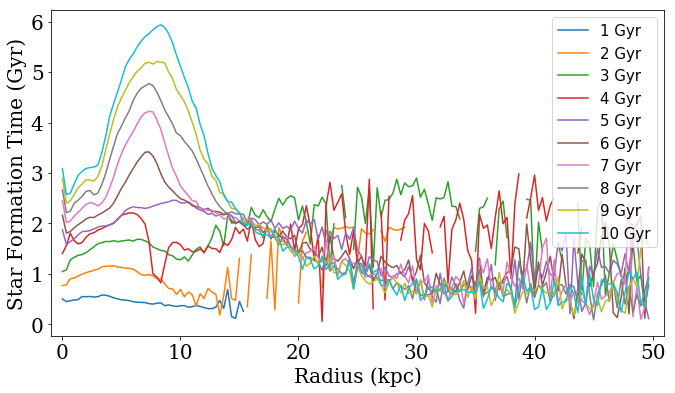

In [11]:
# age profile
plt.figure(figsize=(11,6))
for ii in range(len(age_profiles)):
    plt.plot(xaxis.in_units('kpc'),age_profiles[ii].in_units('Gyr'),
             label=str(ii+1)+' Gyr')
#plt.plot(np.ones(5)*r_1, np.arange(5)*1.5,color='black',linestyle="--")
#plt.plot(np.ones(5)*r_2, np.arange(5)*1.5,color='black',linestyle="--")


plt.ylabel(r'Star Formation Time (Gyr)',fontsize=20, family='serif', weight='ultralight')
plt.xlabel('Radius (kpc)',fontsize=20, family='serif', weight='ultralight')
plt.xticks(fontsize=20, family='serif')
plt.yticks(fontsize=20, family='serif')
plt.xlim([-1,51])
#plt.annotate('$r_1$', xy =( float(r_1)+1, 5.5), fontsize=15 )
#plt.annotate('$r_2$', xy =( float(r_2)+1, 5.5), fontsize=15 )
plt.legend(fontsize=15);
#plt.savefig('694_age_profiles.png',dpi=400)

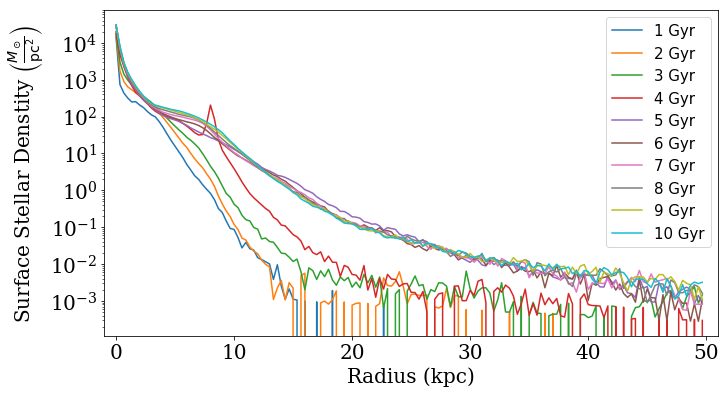

In [12]:
# density profile
plt.figure(figsize=(11,6))
for ii in range(len(age_profiles)):
    plt.plot(xaxis.in_units('kpc'),profiles[ii].in_units('Msun/pc**2'),
             label=str(ii+1)+' Gyr')
#plt.plot(np.ones(5)*r_1, np.arange(5)*1.5,color='black',linestyle="--")
#plt.plot(np.ones(5)*r_2, np.arange(5)*1.5,color='black',linestyle="--")

plt.yscale('log')
plt.ylabel(r'Surface Stellar Denstity $\left(\frac{M_\odot}{\rm{pc}^2}\right)$',
           fontsize=20, family='serif', weight='ultralight')
plt.xlabel('Radius (kpc)',fontsize=20, family='serif', weight='ultralight')
plt.xticks(fontsize=20, family='serif')
plt.yticks(fontsize=20, family='serif')
plt.xlim([-1,51])
#plt.annotate('$r_1$', xy =( float(r_1)+1, 5.5), fontsize=15 )
#plt.annotate('$r_2$', xy =( float(r_2)+1, 5.5), fontsize=15 )
plt.legend(fontsize=15);
#plt.savefig('694_den_profiles.png',dpi=400)

In [72]:
def Density_and_Thick_Profile2( x_field, xunits, y_field, yunits, z_field, zunits, n_bins ):
    import numpy as np
    xaxis   = yt.YTArray(np.zeros(n_bins), xunits)
    yaxis_t = yt.YTArray(np.zeros(n_bins), yunits)
    yaxis   = yt.YTArray(np.zeros(n_bins), yunits+'/'+xunits+'**2')
    zaxis_t = yt.YTArray(np.zeros((n_bins,n_bins)), yunits)
    zaxis   = yt.YTArray(np.zeros((n_bins,n_bins)), yunits+'/'+xunits+'**3')
    xstep   = r_3.in_units(xunits)  / n_bins
    zstep   = np.fabs(z_field).max() / n_bins
    locatex = locatez = 0;
        
    for jj in range(n_bins):# total mass profile
        booleanx = (x_field.in_units(xunits)>jj*xstep) & (x_field.in_units(xunits)<=(jj+1)*xstep)
        yaxis_t[jj] = ( y_field[booleanx].in_units(yunits) ).sum()
    
    for ii in range(n_bins):# radius and density profile
        xaxis[ii] = ii * xstep
        yaxis[ii] = yaxis_t[ii] / (C.pi*(2*ii+1)*xstep**2)
        zaxis[ii] = zaxis_t[ii] / (C.pi*(2*ii+1)*xstep**2) / (2*zstep)
    
    return([xaxis, yaxis, zaxis])

def Age_profile2( x_field, xunits, y_field, yunits, z_field, zunits, n_bins ):
    import numpy as np
    xaxis   = yt.YTArray(np.zeros(n_bins), xunits)
    yaxis_t = yt.YTArray(np.zeros(n_bins), yunits+'*'+zunits)
    yaxis   = yt.YTArray(np.zeros(n_bins), yunits)
    zaxis_t = yt.YTArray(np.zeros((n_bins)), zunits)
    xstep   = r_3.in_units(xunits)  / n_bins
    locatex = 0;
        
    for jj in range(n_bins):# total mass profile
        boolean = (x_field.in_units(xunits)>jj*xstep) & (x_field.in_units(xunits)<=(jj+1)*xstep)
        # evrey radius bin, weighted by mass of stars
        yaxis_t[jj] = (y_field[boolean].in_units(yunits) * z_field[boolean].in_units(zunits)).sum()
        zaxis_t[jj] = z_field[boolean].sum().in_units(zunits)
    for ii in range(n_bins):# radius and density profile
        xaxis[ii] = ii * xstep
        yaxis[ii] = yaxis_t[ii] / zaxis_t[ii]
    
    return([xaxis, yaxis])

In [73]:
def Profiles2(ds_list):
    stellar_profiles = yt.YTArray(np.zeros((len(ds_list),bins)), 'Msun/kpc**2')
    for ii in range(len(ds_list)):
        ds = ds_list[ii]
        centerHost = cen_array[ii]
        sphHost1 = ds.sphere(centerHost, (4, 'kpc'))
        sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
        #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
        norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
        north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]
        # 计算半径和恒星柱密度曲线
        host_galaxy    = ds.disk(centerHost, norm_host, (r_3.item(), "kpc"), (height.item()/2, "kpc"))
        r_cylindrical  = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')
        [xaxis, yaxis, zaxis] = Density_and_Thick_Profile2( r_cylindrical, 'kpc', host_galaxy[('Stars', 'particle_mass')], 'Msun', host_galaxy[('Stars', 'particle_position_relative_z')], 'kpc', bins )
        stellar_profiles[ii] = yaxis
    return [xaxis, stellar_profiles]
bins = 50
[xaxis, profiles] = Profiles2(ds_array)

def Age_Profiles2(ds_list):
    stellar_profiles = yt.YTArray(np.zeros((len(ds_list),bins)), 'Gyr')
    for ii in range(len(ds_list)):
        ds = ds_list[ii]
        centerHost = cen_array[ii]
        sphHost1 = ds.sphere(centerHost, (4, 'kpc'))
        sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
        #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
        norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
        north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]
        # 计算半径和恒星柱密度曲线
        host_galaxy     = ds.disk(centerHost, norm_host, (r_3.item(), "kpc"), (height.item()/2, "kpc"))
        r_cylindrical   = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')
        [radius, yaxis] = Age_profile2(r_cylindrical, 'kpc', host_galaxy[('Stars', 'FormationTime')], 'Gyr',host_galaxy[('Stars', 'Mass')], 'Msun', bins)
        stellar_profiles[ii] = yaxis
        
    return [radius, stellar_profiles]

[xaxis, age_profiles] = Age_Profiles2(ds_array)

/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_velocity_relative' field has been deprecated in favor of 'relative_particle_velocity'.
  dd = self._function(self, data)
/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_position_relative' field has been deprecated in favor of 'relative_particle_position'.
  dd = self._function(self, data)
/home/protesticon/anaconda3/lib/python3.6/site-packages/yt/units/yt_array.py:1394: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


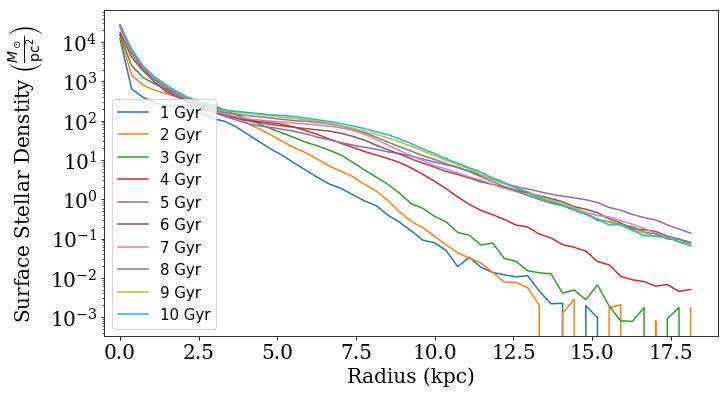

In [76]:
# density profile
plt.figure(figsize=(11,6))
for ii in range(len(age_profiles)):
    plt.plot(xaxis.in_units('kpc'),profiles[ii].in_units('Msun/pc**2'),
             label=str(ii+1)+' Gyr')
#plt.plot(np.ones(5)*r_1, np.arange(5)*1.5,color='black',linestyle="--")
#plt.plot(np.ones(5)*r_2, np.arange(5)*1.5,color='black',linestyle="--")

plt.yscale('log')
plt.ylabel(r'Surface Stellar Denstity $\left(\frac{M_\odot}{\rm{pc}^2}\right)$',
           fontsize=20, family='serif', weight='ultralight')
plt.xlabel('Radius (kpc)',fontsize=20, family='serif', weight='ultralight')
plt.xticks(fontsize=20, family='serif')
plt.yticks(fontsize=20, family='serif')
plt.xlim([-0.5,r_3.item()+0.5])
#plt.annotate('$r_1$', xy =( float(r_1)+1, 5.5), fontsize=15 )
#plt.annotate('$r_2$', xy =( float(r_2)+1, 5.5), fontsize=15 )
plt.legend(fontsize=15);
#plt.savefig('694_den_profiles.png',dpi=400)

In [79]:
r_break = np.zeros(10)
oiratio = np.zeros(10)

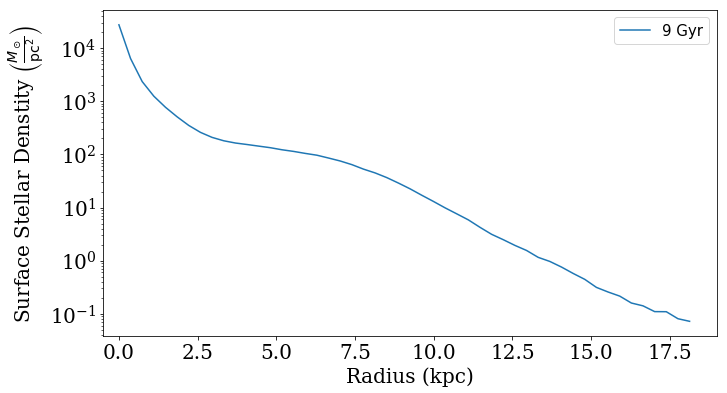

In [128]:
# density profile
plt.figure(figsize=(11,6))
ii = 8
plt.plot(xaxis.in_units('kpc'),profiles[ii].in_units('Msun/pc**2'),
             label=str(ii+1)+' Gyr')
#plt.plot(np.ones(5)*r_2, np.arange(5)*1.5,color='black',linestyle="--")

plt.yscale('log')
plt.ylabel(r'Surface Stellar Denstity $\left(\frac{M_\odot}{\rm{pc}^2}\right)$',
           fontsize=20, family='serif', weight='ultralight')
plt.xlabel('Radius (kpc)',fontsize=20, family='serif', weight='ultralight')
plt.xticks(fontsize=20, family='serif')
plt.yticks(fontsize=20, family='serif')
plt.xlim([-0.5,r_3.item()+0.5])
#plt.annotate('$r_2$', xy =( float(r_2)+1, 5.5), fontsize=15 )
plt.legend(fontsize=15);
#plt.savefig('694_den_profiles.png',dpi=400)

In [135]:
from astropy.convolution import convolve, Box1DKernel
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

def I_fit(r,S,alpha,beta,gamma,r_b):
    return  np.log10(S * np.exp(-1*r/gamma) * ( 1 + np.exp( alpha*(r-r_b) ) )**( 1/alpha * ( 1/gamma - 1/beta ) ) )

def I_show(r,param_set):
    S,alpha,beta,gamma,r_b = param_set.tolist()
    return  S * np.exp(-1*r/gamma) * ( 1 + np.exp( alpha*(r-r_b) ) )**( 1/alpha * ( 1/gamma - 1/beta ) ) 

r_disc    = np.array( xaxis.in_units('kpc') )
dens_disc = np.array( profiles[ii].in_units('Msun/pc**2') )

smoothed_den = convolve(np.log10(dens_disc), Box1DKernel(2))
grad = np.gradient(np.gradient(smoothed_den))
grad = grad[(~np.isnan(grad)) & (~np.isinf(grad))]
for i in range(0,20):
    grad=grad[np.fabs(grad-grad.mean())<=3*np.std(grad,ddof=1)]
    #更新一维数组
    #迭代20次,输出是检查循环的进行 
sigma_profile = grad.std(ddof=1) * 1
'''
for i in range(len(np.gradient(np.gradient(smoothed_den)))):
    if np.fabs(np.gradient(np.gradient(smoothed_den)))[i]<=(sigma_profile) and\
        np.fabs(np.gradient(np.gradient(smoothed_den)))[i+1]<=(sigma_profile) and \
        np.fabs(np.gradient(np.gradient(smoothed_den)))[i+2]<=(sigma_profile) and \
        np.fabs(np.gradient(np.gradient(smoothed_den)))[i+3]<=(sigma_profile):
        break
'''
for i in range(len(np.gradient(np.gradient(smoothed_den)))):
    for j in range(9):
        if np.fabs(np.gradient(np.gradient(smoothed_den)))[i+j]>(sigma_profile):
            break
    if j >= 7:
        break

r_in = np.array(xaxis[i].in_units('kpc'))
r_in = res_robust.x[4]#param_set[4]
print(r_in)

for i in range(len(np.gradient(np.gradient(smoothed_den)))):
    for j in range(5):
        if (np.fabs(np.gradient(np.gradient(smoothed_den)))[-1-i-j]>(sigma_profile))\
            | np.isinf(np.fabs(np.gradient(np.gradient(smoothed_den)))[-1-i-j]) \
            | np.isnan(np.fabs(np.gradient(np.gradient(smoothed_den)))[-1-i-j]):
            break
    if j >= 1:
        break

r_out = np.array(xaxis[-1-i].in_units('kpc'))

for i in range(len(np.gradient(np.gradient(smoothed_den)))-1):
    if (i<len(smoothed_den)-1) & (dens_disc[i] < dens_disc[i+1]) & (r_disc[i]>r_in):
        break
r_out = np.min([r_out, r_disc[i]])

#r_out = 16#13.5#r_disc[dens_disc > 4e-2][-1]
print(r_out)


param_set, param_cov = curve_fit(I_fit, xdata = r_disc[(r_disc>=r_in)&(r_disc<=r_out)&(dens_disc!=0)],
                                 ydata = np.log10(dens_disc)[(r_disc>=r_in)&(r_disc<=r_out)&(dens_disc!=0)],
                                 bounds=([0,0.1,0,0,r_in], [np.inf,1,np.inf,np.inf,r_out]),
                                p0=[1,0.5,1,1,0.5*(min(r_disc)+max(r_disc))],maxfev = 1000000)

if (param_set[2]/param_set[3] > 1.1) or (param_set[2]/param_set[3] < 1/1.1) and (r_in+0.5<=param_set[4]):
    r_break[ii] = param_set[4]
else:
    r_break[ii] = np.nan
oiratio[ii] = param_set[2]/param_set[3]
print(param_set)

8.50557383804627
17.02
[1.96957359e+04 5.24815879e-01 2.40701701e+00 1.35864713e+00
 1.70200000e+01]


In [136]:
def I_rob(param_set,r,y):
    S,alpha,beta,gamma,r_b = param_set.tolist()
    return np.log10( S * np.exp(-1*r/gamma) * ( 1 + np.exp( alpha*(r-r_b) ) )**( 1/alpha * ( 1/gamma - 1/beta ) ) ) - y

res_robust = least_squares(I_rob, param_set, loss='soft_l1', f_scale=0.2,
                           args=(r_disc[(r_disc>=r_in)&(r_disc<=r_out)&(dens_disc!=0)],
                                 np.log10(dens_disc)[(r_disc>=r_in)&(r_disc<=r_out)&(dens_disc!=0)])) 
if res_robust.success == True:
    r_break[ii] = (res_robust.x)[4]
    oiratio[ii] = (res_robust.x)[2] / (res_robust.x)[3]
res_robust.x, res_robust.success, oiratio[ii]

(array([1.99347537e+04, 4.41524970e-01, 2.39223481e+05, 1.35491807e+00,
        1.96841850e+01]), True, 176559.36988045587)

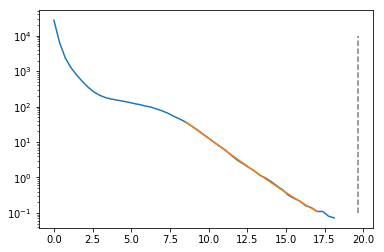

In [137]:
plt.plot(xaxis.in_units('kpc'), profiles[ii].in_units('Msun/pc**2'))
plt.plot(r_disc[(r_disc>=r_in)&(r_disc<=r_out)], I_show(np.array(r_disc[(r_disc>=r_in)&(r_disc<=r_out)]),res_robust.x) )
plt.vlines(r_break[ii], ymin=1e-1, ymax=1e4, linestyles='dashed', alpha=0.5)
plt.yscale('log');

In [155]:
100000 / 100 * 6.3

6300.0